In [36]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [37]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [38]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

In [39]:
table_names = ['corruption_perception', 'life_expectancy', \
               'population_15_64', 'female_legislators', \
               'population_growth', 'under_5_mortality', \
                'zscores']

In [40]:
query = makeSQLQuery(table_names, 2013)

In [41]:
data_2013 = pd.read_sql_query(query, engine)

In [42]:
data_2013 = data_2013.set_index('countrycode')

In [43]:
data_2013['zscores'] = data_2013['zscores'].astype(float)

In [44]:
data_2013.head()

,corruption_perception,life_expectancy,population_15_64,female_legislators,population_growth,under_5_mortality,zscores
countrycode,,,,,,,
AFG,8,60.028268,51.920329,27.7,3.164336,96.7,6.005490
AGO,23,51.866171,49.673340,34.1,3.306205,167.1,-0.232733
ALB,31,77.537244,68.848024,17.9,-0.107730,14.9,-0.003833
ARE,69,77.195634,85.340053,17.5,0.971923,7.4,-0.265036
ARG,34,75.986098,63.834426,NaN,1.047065,13.3,-0.265098


In [45]:

data_2013.loc[data_2013['zscores'] > 0, 'zscores'] = 1
data_2013.loc[data_2013['zscores'] <= 0, 'zscores'] = 0


In [46]:
#The rows to be dropped
data_2013[data_2013.isnull().any(axis=1)]

,corruption_perception,life_expectancy,population_15_64,female_legislators,population_growth,under_5_mortality,zscores
countrycode,,,,,,,
ARG,34,75.986098,63.834426,NaN,1.047065,13.3,0
BLZ,NaN,69.982049,62.518994,3.1,2.198943,17.5,0
CAF,25,49.879878,56.420965,NaN,1.954537,138.5,1
EGY,32,70.925780,62.240369,NaN,2.254326,25.8,0
FJI,NaN,69.917927,65.713066,NaN,0.721403,23.2,0
GIN,24,58.216488,54.003724,NaN,2.714272,100.4,0
GRD,NaN,73.193561,66.079961,33.3,0.403070,12.5,0
KIR,NaN,65.766585,61.033314,8.7,1.788451,58.9,0
MDV,NaN,76.602610,67.509135,6.5,2.056628,9.9,0


In [47]:
data_2013 = data_2013.dropna()

In [48]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value))
    
    return accuracy_score_value, precision_score_value, recall_score_value, f1_score_value, feature_importances

In [49]:
X = data_2013[['corruption_perception', 'life_expectancy', \
               'population_15_64', 'female_legislators', \
               'population_growth', 'under_5_mortality']]
y = data_2013['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [50]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.78
Precision: 0.2727272727272727
Recall: 0.5
f1: 0.3529411764705882


(0.78000000000000003,
 0.27272727272727271,
 0.5,
 0.3529411764705882,
 array([ 0.22027979,  0.07562657,  0.22252747,  0.26984418,  0.08239868,
         0.12932331]))

In [51]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.88
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.88, 0.0, 0.0, 0.0, None)

In [52]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.72
Precision: 0.2777777777777778
Recall: 0.8333333333333334
f1: 0.4166666666666667


(0.71999999999999997,
 0.27777777777777779,
 0.83333333333333337,
 0.41666666666666669,
 None)

In [53]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.88
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.88, 0.0, 0.0, 0.0, None)

In [54]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.84
Precision: 0.25
Recall: 0.16666666666666666
f1: 0.2


(0.83999999999999997,
 0.25,
 0.16666666666666666,
 0.20000000000000001,
 array([ 0.29610819,  0.10467599,  0.23702528,  0.15473531,  0.09809481,
         0.10936042]))

In [55]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.7916666666666667


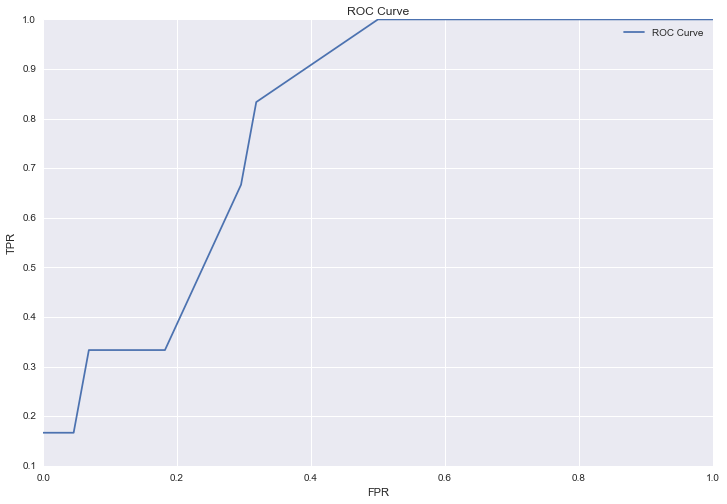

In [56]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [57]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [58]:
getScoreValuesByCV(X,y)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8354166666666668
Precision: 0.1
Recall: 0.04
f1: 0.05714285714285715
ROC AUC: 0.631031746031746


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8352272727272727
Precision: 0.21666666666666665
Recall: 0.16
f1: 0.26031746031746034
ROC AUC: 0.7285449735449735


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7556818181818181
Precision: 0.34898989898989896
Recall: 0.44000000000000006
f1: 0.3664085914085914
ROC AUC: 0.6741798941798942


In [61]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.8168560606060605
Precision: 0.386031746031746
Recall: 0.36
f1: 0.4197435897435898
ROC AUC: 0.6550529100529101


In [62]:
getScoreValuesByCV(X,y, model=LogisticRegression())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8598484848484848
Precision: 0.5
Recall: 0.12000000000000002
f1: 0.1904761904761905
ROC AUC: 0.6934391534391534


## Over sampling

In [63]:
x_cols = ['corruption_perception', 'life_expectancy', \
               'population_15_64', 'female_legislators', \
               'population_growth', 'under_5_mortality' ]

In [64]:
X = data_2013[x_cols]
y = data_2013['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [65]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [66]:
#smox

In [67]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [68]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.72
Precision: 0.25
Recall: 0.6666666666666666
f1: 0.36363636363636365


(0.71999999999999997,
 0.25,
 0.66666666666666663,
 0.36363636363636365,
 array([ 0.17517183,  0.21489303,  0.19711195,  0.1325766 ,  0.10057066,
         0.17967592]))

In [69]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.14
Precision: 0.12244897959183673
Recall: 1.0
f1: 0.2181818181818182


(0.14000000000000001, 0.12244897959183673, 1.0, 0.2181818181818182, None)

In [70]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.54
Precision: 0.18518518518518517
Recall: 0.8333333333333334
f1: 0.303030303030303


(0.54000000000000004,
 0.18518518518518517,
 0.83333333333333337,
 0.30303030303030298,
 None)

In [71]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.62
Precision: 0.21739130434782608
Recall: 0.8333333333333334
f1: 0.3448275862068966


(0.62,
 0.21739130434782608,
 0.83333333333333337,
 0.34482758620689657,
 array([ 0.23535232,  0.25928139,  0.10037361,  0.21108368,  0.14566136,
         0.04824764]))

In [72]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.58
Precision: 0.17391304347826086
Recall: 0.6666666666666666
f1: 0.27586206896551724


(0.57999999999999996,
 0.17391304347826086,
 0.66666666666666663,
 0.27586206896551724,
 None)

## Confusion Matrix

In [73]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with oversampling

In [74]:
def getCrossValScoresBySSS(local_X, 
                           local_y, 
                           n_iter=30, 
                           test_size=0.3, 
                           model=KNeighborsClassifier(n_neighbors=6),
                           get_multi_models=False,
                           get_models_avg=False,
                           get_cm=False,
                           verbose=True,
                           get_features=True
                          ):
    
    score_dict = {}
    acc_array = []
    prec_array = []
    recall_array = []
    f1_array = []
    feature_imp_array = []
    sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    model_list = [\
                  KNeighborsClassifier(n_neighbors=6), \
                  LogisticRegression(), \
                  GaussianNB(), \
                  RandomForestClassifier(), \
                  DecisionTreeClassifier() \
                  ]
    
    #Return table of scores for each model
    if get_multi_models:
        model_acc = []
        model_prec = []
        model_rec = []
        model_f1 = []
        for a_model in model_list:
            acc_array = []
            prec_array = []
            recall_array = []
            f1_array = []
            for train_index, test_index in sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X.ix[train_index], X.ix[test_index]
                y_train, y_test = y.ix[train_index], y.ix[test_index]

                X_train = X_train.reset_index(drop=True).as_matrix()
                y_train = y_train.reset_index(drop=True).as_matrix()

                smote = SMOTE(ratio=ratio, verbose=False)
                smox, smoy = smote.fit_transform(X_train, y_train)
                X_train = pd.DataFrame(smox, columns=x_cols)
                y_train = pd.Series(smoy)
            
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, _ = getScoreValues(X_train, 
                                                                   X_test, 
                                                                   y_train, 
                                                                   y_test, 
                                                                   model=a_model, 
                                                                   verbose=False,
                                                                   get_features=False)
                
                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                
            mean_acc = np.mean(acc_array)
            mean_prec = np.mean(prec_array)
            mean_recall = np.mean(recall_array)
            mean_f1 = np.mean(f1_array)
            
            model_acc.append(mean_acc)
            model_prec.append(mean_prec)
            model_rec.append(mean_recall)
            model_f1.append(mean_f1)
            
        score_dict['Accuracy'] = model_acc
        score_dict['Precision'] = model_prec
        score_dict['Recall'] = model_rec
        score_dict['F1'] = model_f1
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1']
        index_func = [\
                  'KNeighborsClassifier(n_neighbors=6)', \
                  'LogisticRegression()', \
                  'GaussianNB()', \
                  'RandomForestClassifier()', \
                  'DecisionTreeClassifier()' \
                  ]
        df = pd.DataFrame(score_dict, columns=col_names, index=index_func)
        return df
    
    
    else:
        for train_index, test_index in sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            X_train = X_train.reset_index(drop=True).as_matrix()
            y_train = y_train.reset_index(drop=True).as_matrix()

            smote = SMOTE(ratio=ratio, verbose=False)
            smox, smoy = smote.fit_transform(X_train, y_train)
            X_train = pd.DataFrame(smox, columns=x_cols)
            y_train = pd.Series(smoy)

            #Get scores of the average prediction of multiple models
            if get_models_avg:
                y_predictions = []

                for a_model in model_list:
                    temp_model = a_model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_predictions.append(y_pred)

                average_prediction = np.mean(y_predictions, axis=0)
                average_prediction = [int(round(n, 0)) for n in average_prediction]

                accuracy_score_value = accuracy_score(y_test, y_pred)
                precision_score_value = precision_score(y_test, y_pred)
                recall_score_value = recall_score(y_test, y_pred)
                f1_score_value = f1_score(y_test, y_pred)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)

            #Get score values for each fold
            else:
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, \
                feature_importances = getScoreValues(X_train, 
                                                     X_test, 
                                                     y_train,
                                                     y_test, 
                                                     model=model, 
                                                     verbose=False,
                                                     get_features=get_features)

                if get_cm:
                    # For getting a confusion matrix of the last model in the cross validated set
                    temp_model = model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                feature_imp_array.append(feature_importances)

        if get_cm:
            cm = confusion_matrix(y_test, average_prediction)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(acc_array)
        mean_prec = np.mean(prec_array)
        mean_recall = np.mean(recall_array)
        mean_f1 = np.mean(f1_array)
        try:
            mean_feature_imp = np.mean(feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
            
            
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(mean_acc, \
                                                                           mean_prec, \
                                                                           mean_recall,\
                                                                           mean_f1))

In [75]:
X = data_2013[x_cols]
y = data_2013['zscores']

## Scores for various models

In [76]:
getCrossValScoresBySSS(X, y, get_multi_models=True)

,Accuracy,Precision,Recall,F1
KNeighborsClassifier(n_neighbors=6),0.629333,0.206479,0.470833,0.284929
LogisticRegression(),0.601333,0.217485,0.570833,0.312034
GaussianNB(),0.640667,0.245245,0.570833,0.338287
RandomForestClassifier(),0.742667,0.245007,0.283333,0.256363
DecisionTreeClassifier(),0.682000,0.164581,0.262500,0.198612


#### KNN various n


In [77]:
for n in range(1,8):
    print('n = ', n)
    getCrossValScoresBySSS(X, y, model=KNeighborsClassifier(n_neighbors=n))
    print('\n')

n =  1
Avg Feature Importance: None
Accuracy: 0.6693333333333332
Precision: 0.2157525844754947
Recall: 0.4
f1: 0.27801880441257665


n =  2
Avg Feature Importance: None
Accuracy: 0.7159999999999999
Precision: 0.22203520937267066
Recall: 0.3
f1: 0.25220660488960395


n =  3
Avg Feature Importance: None
Accuracy: 0.6266666666666667
Precision: 0.21243280618880744
Recall: 0.4875
f1: 0.29271284559557054


n =  4
Avg Feature Importance: None
Accuracy: 0.642
Precision: 0.18330450681069876
Recall: 0.3625
f1: 0.24061461838076


n =  5
Avg Feature Importance: None
Accuracy: 0.6046666666666666
Precision: 0.204802457325823
Recall: 0.5291666666666667
f1: 0.2936711941363406


n =  6
Avg Feature Importance: None
Accuracy: 0.6399999999999998
Precision: 0.21510888197343306
Recall: 0.4625
f1: 0.2885898964575876


n =  7
Avg Feature Importance: None
Accuracy: 0.5853333333333334
Precision: 0.20155844848648485
Recall: 0.5541666666666667
f1: 0.29365569306948613




#### Random Forest for important features

In [82]:
getCrossValScoresBySSS(X, y, model=RandomForestClassifier())

Avg Feature Importance: [ 0.17530619  0.19727087  0.1658762   0.14700993  0.14313543  0.17140138]
Accuracy: 0.7186666666666668
Precision: 0.21700153590246465
Recall: 0.275
f1: 0.23203284269428207


#### DecisionTreeClassifier for important features

In [84]:
getCrossValScoresBySSS(X, y, model=DecisionTreeClassifier())

Avg Feature Importance: [ 0.17106925  0.22420251  0.19657858  0.13249339  0.14842309  0.12723318]
Accuracy: 0.704
Precision: 0.2386054860745263
Recall: 0.3625
f1: 0.28217127589310925


### Model averages:

In [80]:
getCrossValScoresBySSS(X, y, get_models_avg=True)

Avg Feature Importance: nan
Accuracy: 0.6406666666666666
Precision: 0.2009356367796266
Recall: 0.4375
f1: 0.27173622660632824


/Users/kenn/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
